In [ ]:
# Matthew Dickey Neuro140 Project

# Using a weather classification CNN based on a pretrained ResNet50 model to test image interpolation and adjustment techniques on model performance

# Dataset used: https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset

In [1]:
import os

# Confirms access to correct dataset with expected subdirectories
data_dir = 'dataset/'
print(os.listdir(data_dir))

['cloudy', '.DS_Store', 'shine', 'sunrise', 'rainy', 'foggy']


In [4]:
# Confirms dataset1 contains 5 weather categorizations
print(dataset1.classes)

# Confirms length of dataset1
print('dataset1:', len(dataset1))


['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
dataset1: 1500


In [5]:
# Defines a dictionary to store the count for each class
class_count = {}

# Iterates through the class names
for class_name in dataset1.classes:
    # Gets the indices of all the images for the current class
    indices = [i for i, (_, label) in enumerate(dataset1) if label == dataset1.class_to_idx[class_name]]
    # Counts the number of images for the current class and store it in the dictionary
    class_count[class_name] = len(indices)

# Prints the count for each class
for class_name, count in class_count.items():
    print(f"{class_name}: {count}")
    
# Confirms expected number of images for each weather class

cloudy: 300
foggy: 300
rainy: 300
shine: 250
sunrise: 350


In [334]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

# transform1 will serve as the default image resizing for baseline comparisons
transform1 = transforms.Compose([
    transforms.Resize((64, 64)),  # Resizes the images to 64x64
    transforms.ToTensor(), # Converts the images to PyTorch tensors
    transforms.Normalize(mean=[0.4658, 0.4615, 0.4531], std=[0.2164, 0.1912, 0.1826]) # Normalizes tensor array
]) 

# Simple transformation that does not take advantage of any interpolation techniques

In [335]:
# Uses ImageFolder to establish dataset1 with baseline image transformation
dataset1 = datasets.ImageFolder(root=data_dir, transform=transform1)

In [227]:
import matplotlib.pyplot as plt
import random

# Function to print transformed image

def print_transformed_image(dataset):

    # Indexes a random image from the dataset
    index = random.randint(0, len(dataset) - 1)

    # Gets the image and its label
    image, label = dataset[index]

    # Defines class names
    class_names = dataset.classes

    # Plots the image
    plt.imshow(image.permute(1, 2, 0)) # adjusts image dimensions for imshow to plot properly

    # Adds class label as title
    plt.title(class_names[label])
    print('Label: ', dataset.classes[label])

    # Shows the plot
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  rainy


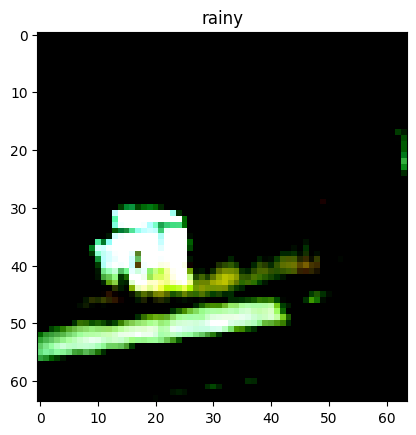

In [228]:
# IMAGE for dataset1

print_transformed_image(dataset1)

In [229]:
import torch.utils.data as data

# dataset1

# Defines the ratio of the dataset to use for training
train_ratio = 0.8

# Calculates the sizes of the training and testing sets
train_size = int(train_ratio * len(dataset1))
test_size = len(dataset1) - train_size

# Uses random_split to split the dataset into training and testing sets
train_dataset, test_dataset = data.random_split(dataset1, [train_size, test_size])

In [230]:
# This method of using the DataLoader class with a pretrained model learned at: https://github.com/chiragdaryani/Weather-Images-Classification-in-PyTorch/blob/main/Weather_Images_Classification_Project_Final_Submission.ipynb
# As well as learned here: https://pytorch.org/docs/stable/optim.html

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

batch_size = 15

# Loads training data and testing data into a dataloader
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Defines the pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Modifies last layer of model to match dataset1
# These lines of code were added only after I ran the original error message through ChatGPT
    # One of the layers of the model expects a certain input and caused an error, this adjusts it to expect the input from my dataset
num_classes = len(dataset1.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Defines the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [231]:
import time

# Trains dataset1 on the pretrained Resnet50 architecture for 6 epochs
num_epochs = 6

# Stores values from each epoch
train_losses = []
train_accs = []

# Tracks training time
start_time = time.time()


# Starts training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    # Sets the model to train mode
    model.train()

    # Initializes the running loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    
    # Iterates over the training data loader
    for inputs, labels in train_loader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Updates running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    # Calculates average training loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.double() / len(train_dataset)
    
    # Appends training loss and accuracy to the corresponding lists
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Prints loss and accuracy for each epoch
    print(f"Training loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    
# Tracks training time
end_time = time.time()

training_time = end_time - start_time

print(f"Total training time: {training_time:.2f} seconds")

Epoch 1/6
--------------------
Training loss: 0.7480, accuracy: 0.7392
Epoch 2/6
--------------------
Training loss: 0.3053, accuracy: 0.8983
Epoch 3/6
--------------------
Training loss: 0.2009, accuracy: 0.9433
Epoch 4/6
--------------------
Training loss: 0.1227, accuracy: 0.9592
Epoch 5/6
--------------------
Training loss: 0.1192, accuracy: 0.9617
Epoch 6/6
--------------------
Training loss: 0.1027, accuracy: 0.9650
Total training time: 626.65 seconds


In [288]:
# Funciton to plot training loss
# Based on the same GitHub linked before

def training_loss_plot(training_losses):

    # Plots the training loss
    plt.plot(np.arange(1, num_epochs+1), training_losses)
    plt.xticks(np.arange(1, num_epochs+1))
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [284]:
# Function to plot training accuracy

def training_accuracy_plot(training_accuracy):

    # Plots the training accuracy
    plt.plot(np.arange(1, num_epochs+1), training_accuracy) # set x-axis ticks
    plt.xticks(np.arange(1, num_epochs+1)) # set x-axis tick labels
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

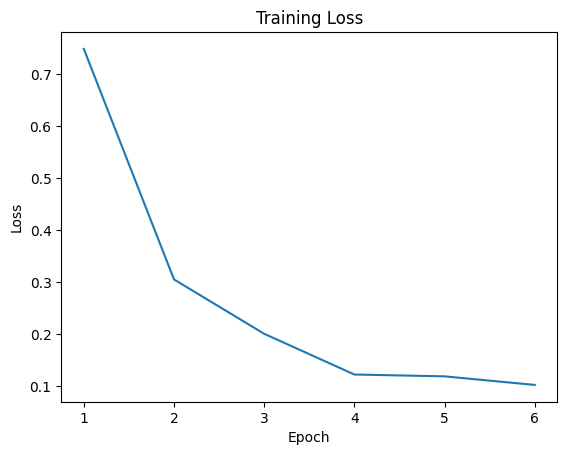

In [289]:
# Training loss over epochs for transformation1

training_loss_plot(train_losses)

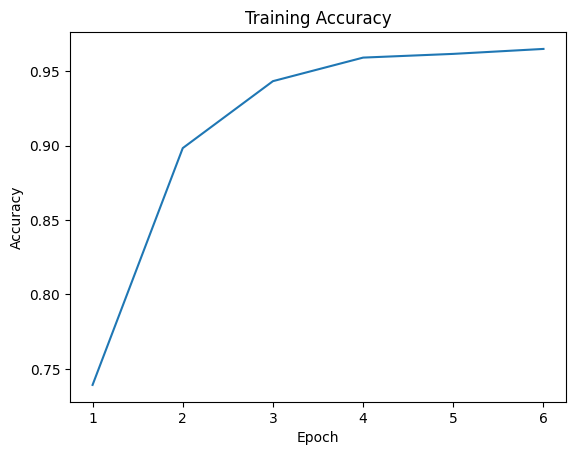

In [285]:
# Training accuracy over epochs for transformation1

training_accuracy_plot(train_accs)

In [236]:
# dataset1 test

# Stores model predictions
input_images = []
true_labels = []
predicted_labels = []

# Evaluate the model on the testing data
model.eval()

# Tracks testing time
start_time = time.time()


# Starts testing loop
with torch.no_grad():
    # Initializes the running loss and correct predictions
    running_loss = 0.0
    running_corrects = 0

    # Iterates over the testing data loader
    for inputs, labels in test_loader:
        
        # Stores input images and true labels for later use
        input_images.extend(inputs)
        true_labels.extend(labels)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Updates running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
        # Stores predicted labels for later use
        predicted_labels.extend(preds)

    # Calculates the average testing loss and accuracy for the epoch
    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)
    
    # Prints loss and accuracy for test
    print(f"Testing loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

# Tracks testing time
end_time = time.time()

testing_time = end_time - start_time

print(f"Total testing time: {testing_time:.2f} seconds")

Testing loss: 0.1691, accuracy: 0.9367
Total testing time: 26.48 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


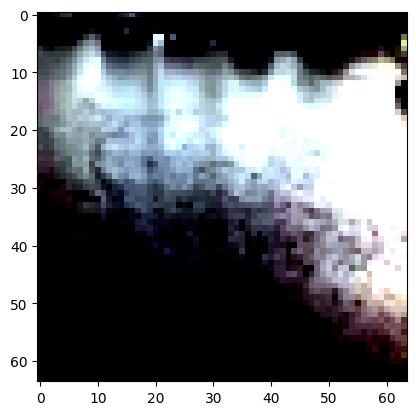

Predicted label: rainy, True label: rainy


In [241]:
# Predicted image output with labels idea from previous GitHub, code my own

import numpy as np

#Predicts image for dataset1

# Iterates through each list created during the test
input_images = [img for img in input_images]
true_labels = [lbl for lbl in true_labels]
predicted_labels = [pred for pred in predicted_labels]

# Indexes a random image from the dataset
index = random.randint(0, len(input_images) - 1)

# Takes the image, true label and predicted label of indexed image
image = input_images[index]
true_label = true_labels[index]
predicted_label = predicted_labels[index]

# Transforms image for display
image = image.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.show()

# Prints true and predicted label with image plot
print(f"Predicted label: {dataset1.classes[predicted_label]}, True label: {dataset1.classes[true_label]}")

In [244]:
# transform2 to test bicubic interpolation
transform2 = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC), # Interpolation method is bicubic
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4658, 0.4615, 0.4531], std=[0.2164, 0.1912, 0.1826])
])
# Sizes image up from baseline under bicubic method

In [245]:
# Establishes dataset2 using transform2 method
dataset2 = datasets.ImageFolder(root=data_dir, transform=transform2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  rainy


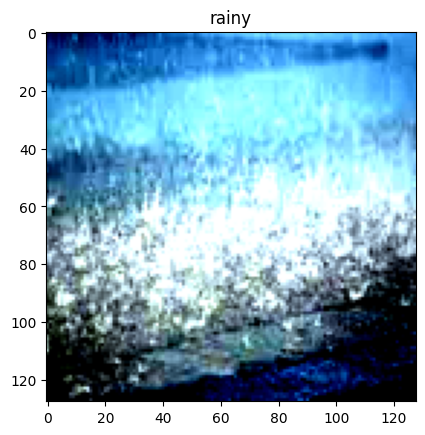

In [246]:
# IMAGE for dataset2

print_transformed_image(dataset2)

In [247]:
# The following steps for dataset2 and all other datasets are identical to that for dataset1

# dataset2

# Defines the ratio of the dataset to use for training
train_ratio = 0.8

# Calculates the sizes of the training and testing sets
train_size2 = int(train_ratio * len(dataset2))
test_size2 = len(dataset2) - train_size2

# Uses random_split to split the dataset into training and testing sets
train_dataset2, test_dataset2 = data.random_split(dataset2, [train_size2, test_size2])

In [248]:
batch_size = 15

train_loader2 = data.DataLoader(train_dataset2, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader2 = data.DataLoader(test_dataset2, batch_size=batch_size, shuffle=False, num_workers=4)

# Defines the pretrained ResNet50 model
model2 = models.resnet50(pretrained=True)

# Modifies last layer of model to match dataset2
num_classes = len(dataset2.classes)
model2.fc = nn.Linear(model2.fc.in_features, num_classes)

# Defines the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [249]:
# Trains dataset2 on the pretrained Resnet50 architecture for 6 epochs
num_epochs = 6

# Stores values from each epoch
train_losses2 = []
train_accs2 = []

# Tracks training time
start_time = time.time()

# Starts training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    # Sets the model to train mode
    model2.train()

    # Initializes the running loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    
    # Iterates over the training data loader
    for inputs, labels in train_loader2:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model2(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Updates running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    # Calculates average training loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataset2)
    train_acc = running_corrects.double() / len(train_dataset2)
    
    # Appends training loss and accuracy to the corresponding lists
    train_losses2.append(train_loss)
    train_accs2.append(train_acc)
    
    # Prints loss and accuracy for each epoch
    print(f"Training loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    
# Tracks training time
end_time = time.time()

training_time = end_time - start_time

print(f"Total training time: {training_time:.2f} seconds")

Epoch 1/6
--------------------
Training loss: 0.7035, accuracy: 0.7700
Epoch 2/6
--------------------
Training loss: 0.1878, accuracy: 0.9333
Epoch 3/6
--------------------
Training loss: 0.1192, accuracy: 0.9642
Epoch 4/6
--------------------
Training loss: 0.0673, accuracy: 0.9808
Epoch 5/6
--------------------
Training loss: 0.0495, accuracy: 0.9867
Epoch 6/6
--------------------
Training loss: 0.0270, accuracy: 0.9942
Total training time: 1174.47 seconds


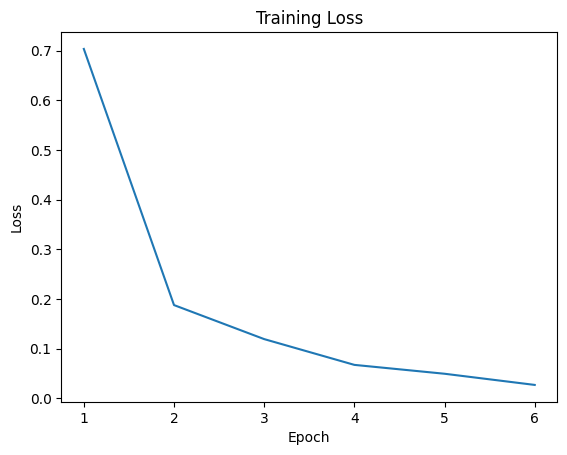

In [290]:
# Training loss over epochs for dataset2

training_loss_plot(train_losses2)

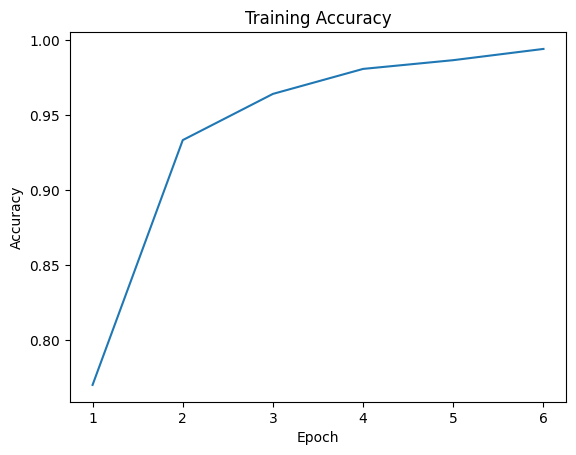

In [291]:
# Training accuracy over epochs for dataset2

training_accuracy_plot(train_accs2)

In [252]:
# dataset2 test

# Stores model2 predictions
input_images2 = []
true_labels2 = []
predicted_labels2 = []

# Evaluate the model on the testing data
model2.eval()

# Tracks testing time
start_time = time.time()

# Starts testing loop
with torch.no_grad():
    # Initializes the running loss and correct predictions
    running_loss = 0.0
    running_corrects = 0

    # Iterates over the testing data loader
    for inputs, labels in test_loader2:
        
        # Stores input images and true labels for later use
        input_images2.extend(inputs)
        true_labels2.extend(labels)

        # Forward pass
        outputs = model2(inputs)
        loss = criterion(outputs, labels)

        # Updates running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
        # Stores predicted labels for later use
        predicted_labels2.extend(preds)

    # Calculates the average testing loss and accuracy for the epoch
    test_loss = running_loss / len(test_dataset2)
    test_acc = running_corrects.double() / len(test_dataset2)
    
    # Prints loss and accuracy for test
    print(f"Testing loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
    
# Tracks testing time
end_time = time.time()

testing_time = end_time - start_time

print(f"Total testing time: {testing_time:.2f} seconds")

Testing loss: 0.0782, accuracy: 0.9767
Total testing time: 32.22 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


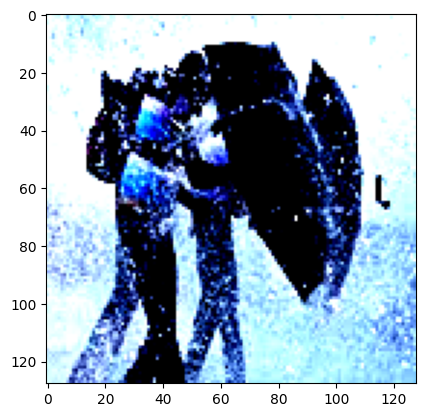

Predicted label: rainy, True label: rainy


In [253]:
# Prediction for dataset2

# iterates through each list created during the test
input_images2 = [img for img in input_images2]
true_labels2 = [lbl for lbl in true_labels2]
predicted_labels2 = [pred for pred in predicted_labels2]

# Indexes a random image from the dataset
index = random.randint(0, len(input_images2) - 1)

# Takes the image, true label and predicted label of indexed image
image2 = input_images2[index]
true_label2 = true_labels2[index]
predicted_label2 = predicted_labels2[index]

# Transforms image for display
image2 = image2.numpy().transpose((1, 2, 0))
plt.imshow(image2)
plt.show()

# Prints true and predicted label with image plot
print(f"Predicted label: {dataset2.classes[predicted_label2]}, True label: {dataset2.classes[true_label2]}")

In [384]:
# transform3 to test zero-pixel padding
transform3 = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BICUBIC), # Resizes the image to a larger size with bicubic interpolation
    transforms.RandomCrop(128), # Randomly crops the image to the original input size
    transforms.Pad(padding=32, fill=(255, 255, 255), padding_mode='constant'), # Adds a 32-pixel white border around the image
    transforms.ToTensor(), # Converts the image to a PyTorch tensor
    transforms.Normalize(mean=[0.7626, 0.7607, 0.7570], std=[0.3084, 0.3017, 0.3063]) # Normalizes tensor array
])

In [385]:
# Establishes dataset3 using transform3 method
dataset3 = datasets.ImageFolder(root=data_dir, transform=transform3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  rainy


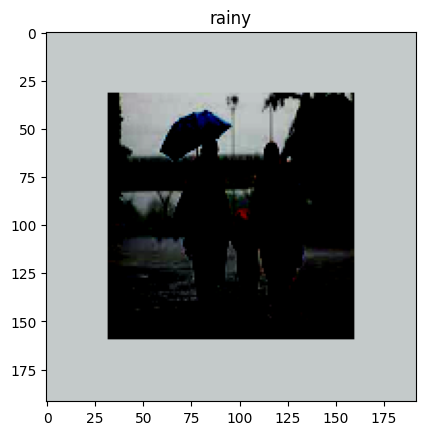

In [386]:
# IMAGE for dataset3

print_transformed_image(dataset3)

In [387]:
# dataset3

# Defines the ratio of the dataset to use for training
train_ratio = 0.8

# Calculates the sizes of the training and testing sets
train_size3 = int(train_ratio * len(dataset3))
test_size3 = len(dataset3) - train_size3

# Uses random_split to split the dataset into training and testing sets
train_dataset3, test_dataset3 = data.random_split(dataset3, [train_size3, test_size3])

In [388]:
batch_size = 15

train_loader3 = data.DataLoader(train_dataset3, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader3 = data.DataLoader(test_dataset3, batch_size=batch_size, shuffle=False, num_workers=4)

# Defines the pretrained ResNet50 model
model3 = models.resnet50(pretrained=True)

# Modifies last layer of model to match dataset2
num_classes = len(dataset3.classes)
model3.fc = nn.Linear(model3.fc.in_features, num_classes)

# Defines the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [389]:
# Trains dataset3 on the pretrained Resnet50 architecture for 6 epochs
num_epochs = 6

# Stores values from each epoch
train_losses3 = []
train_accs3 = []

# Tracks training time
start_time = time.time()

# Starts training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    # Sets the model to train mode
    model3.train()

    # Initializes the running loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    
    # Iterates over the training data loader
    for inputs, labels in train_loader3:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model3(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Updates running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    # Calculates average training loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataset3)
    train_acc = running_corrects.double() / len(train_dataset3)
    
    # Appends training loss and accuracy to the corresponding lists
    train_losses3.append(train_loss)
    train_accs3.append(train_acc)
    
    # Prints loss and accuracy for each epoch
    print(f"Training loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    
# Tracks training time
end_time = time.time()

training_time = end_time - start_time

print(f"Total training time: {training_time:.2f} seconds")

Epoch 1/6
--------------------
Training loss: 0.7191, accuracy: 0.7633
Epoch 2/6
--------------------
Training loss: 0.1977, accuracy: 0.9342
Epoch 3/6
--------------------
Training loss: 0.1144, accuracy: 0.9608
Epoch 4/6
--------------------
Training loss: 0.0738, accuracy: 0.9792
Epoch 5/6
--------------------
Training loss: 0.0386, accuracy: 0.9917
Epoch 6/6
--------------------
Training loss: 0.0286, accuracy: 0.9942
Total training time: 2074.58 seconds


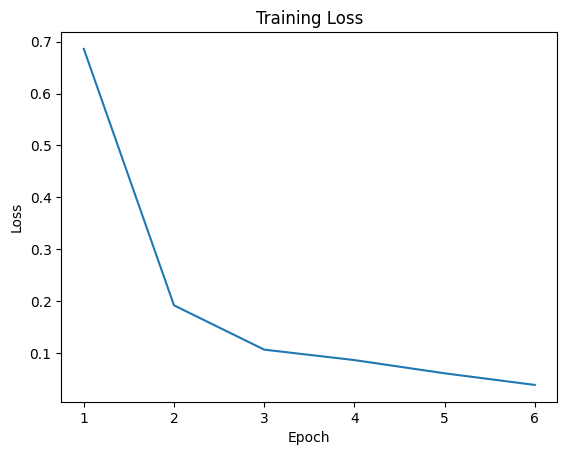

In [354]:
# Training loss over epochs for dataset3

training_loss_plot(train_losses3)

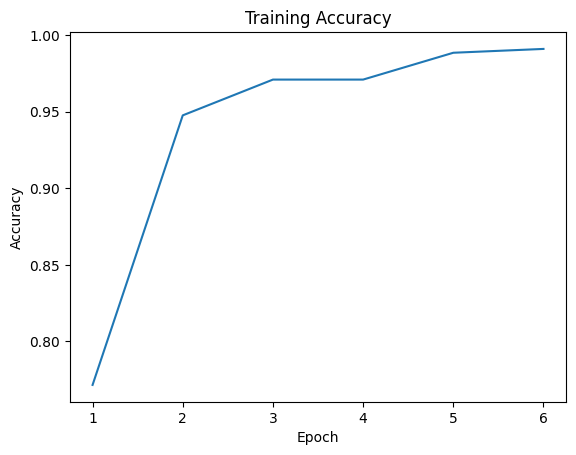

In [355]:
# Training accuracy over epochs for dataset3

training_accuracy_plot(train_accs3)

In [279]:
# dataset3 test

# Stores model3 predictions
input_images3 = []
true_labels3 = []
predicted_labels3 = []

# Evaluate the model on the testing data
model3.eval()

# Tracks testing time
start_time = time.time()

# Starts testing loop
with torch.no_grad():
    # Initializes the running loss and correct predictions
    running_loss = 0.0
    running_corrects = 0

    # Iterates over the testing data loader
    for inputs, labels in test_loader3:
        
        # Stores input images and true labels for later use
        input_images3.extend(inputs)
        true_labels3.extend(labels)

        # Forward pass
        outputs = model3(inputs)
        loss = criterion(outputs, labels)

        # Updates running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
        # Stores predicted labels for later use
        predicted_labels3.extend(preds)

    # Calculates the average testing loss and accuracy for the epoch
    test_loss = running_loss / len(test_dataset3)
    test_acc = running_corrects.double() / len(test_dataset3)
    
    # Prints loss and accuracy for test
    print(f"Testing loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
    
# Tracks testing time
end_time = time.time()

testing_time = end_time - start_time

print(f"Total testing time: {testing_time:.2f} seconds")

Testing loss: 0.2667, accuracy: 0.9400
Total testing time: 39.07 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


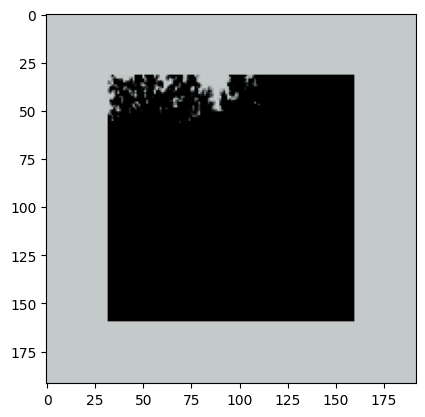

Predicted label: rainy, True label: rainy


In [280]:
# Prediction for dataset3

# iterates through each list created during the test
input_images3 = [img for img in input_images3]
true_labels3 = [lbl for lbl in true_labels3]
predicted_labels3 = [pred for pred in predicted_labels3]

# Indexes a random image from the dataset
index = random.randint(0, len(input_images3) - 1)

# Takes the image, true label and predicted label of indexed image
image3 = input_images3[index]
true_label3 = true_labels3[index]
predicted_label3 = predicted_labels3[index]

# Transforms image for display
image3 = image3.numpy().transpose((1, 2, 0))
plt.imshow(image3)
plt.show()

# Prints true and predicted label with image plot
print(f"Predicted label: {dataset3.classes[predicted_label3]}, True label: {dataset3.classes[true_label3]}")

In [346]:
# transform4 adjusts brightness, contrast, hue, saturation
transform4 = transforms.Compose([
    transforms.Resize((64, 64)),  # Resizes the images to 64x64
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Adjusts brightness, contrast, saturation, and hue randomly
    transforms.ToTensor(), # Converts the images to PyTorch tensors
    transforms.Normalize(mean=[0.4609, 0.4567, 0.4480], std=[0.2137, 0.1919, 0.1814]) # Normalizes tensory array
]) 


In [347]:
# Establishes dataset4 using transform4 method
dataset4 = datasets.ImageFolder(root=data_dir, transform=transform4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  sunrise


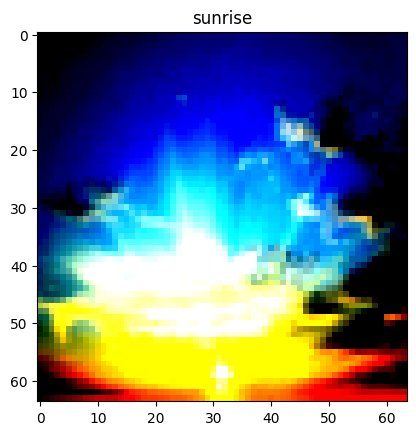

In [350]:
# IMAGE for dataset4

print_transformed_image(dataset4)

In [351]:
# dataset4

# Defines the ratio of the dataset to use for training
train_ratio = 0.8

# Calculates the sizes of the training and testing sets
train_size4 = int(train_ratio * len(dataset4))
test_size4 = len(dataset4) - train_size4

# Uses random_split to split the dataset into training and testing sets
train_dataset4, test_dataset4 = data.random_split(dataset4, [train_size4, test_size4])

In [352]:
batch_size = 15

train_loader4 = data.DataLoader(train_dataset4, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader4 = data.DataLoader(test_dataset4, batch_size=batch_size, shuffle=False, num_workers=4)

# Defines the pretrained ResNet50 model
model4 = models.resnet50(pretrained=True)

# Modifies last layer of model to match dataset2
num_classes = len(dataset4.classes)
model4.fc = nn.Linear(model4.fc.in_features, num_classes)

# Defines the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model4.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [353]:
# Trains dataset4 on the pretrained Resnet50 architecture for 6 epochs
num_epochs = 6

# Stores values from each epoch
train_losses4 = []
train_accs4 = []

# Tracks training time
start_time = time.time()

# Starts training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    # Sets the model to train mode
    model4.train()

    # Initializes the running loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    
    # Iterates over the training data loader
    for inputs, labels in train_loader4:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model4(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Updates running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    # Calculates average training loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataset4)
    train_acc = running_corrects.double() / len(train_dataset4)
    
    # Appends training loss and accuracy to the corresponding lists
    train_losses4.append(train_loss)
    train_accs4.append(train_acc)
    
    # Prints loss and accuracy for each epoch
    print(f"Training loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    
# Tracks training time
end_time = time.time()

training_time = end_time - start_time

print(f"Total training time: {training_time:.2f} seconds")

Epoch 1/6
--------------------
Training loss: 0.7979, accuracy: 0.7108
Epoch 2/6
--------------------
Training loss: 0.3366, accuracy: 0.8842
Epoch 3/6
--------------------
Training loss: 0.2331, accuracy: 0.9208
Epoch 4/6
--------------------
Training loss: 0.1726, accuracy: 0.9442
Epoch 5/6
--------------------
Training loss: 0.1489, accuracy: 0.9567
Epoch 6/6
--------------------
Training loss: 0.0994, accuracy: 0.9700
Total training time: 590.14 seconds


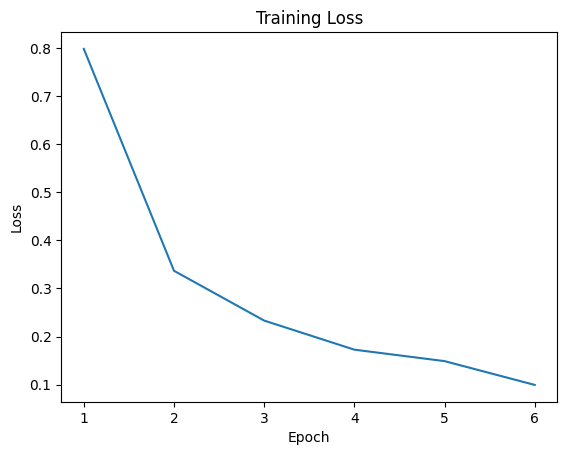

In [356]:
# Training loss over epochs for dataset4

training_loss_plot(train_losses4)

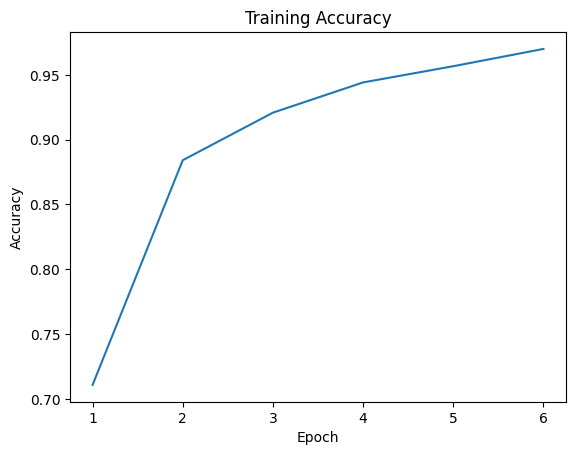

In [357]:
# Training accuracy over epochs for dataset4

training_accuracy_plot(train_accs4)

In [358]:
# dataset4 test

# Stores model4 predictions
input_images4 = []
true_labels4 = []
predicted_labels4 = []

# Evaluate the model on the testing data
model4.eval()

# Tracks testing time
start_time = time.time()

# Starts testing loop
with torch.no_grad():
    # Initializes the running loss and correct predictions
    running_loss = 0.0
    running_corrects = 0

    # Iterates over the testing data loader
    for inputs, labels in test_loader4:
        
        # Stores input images and true labels for later use
        input_images4.extend(inputs)
        true_labels4.extend(labels)

        # Forward pass
        outputs = model4(inputs)
        loss = criterion(outputs, labels)

        # Updates running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
        # Stores predicted labels for later use
        predicted_labels4.extend(preds)

    # Calculates the average testing loss and accuracy for the epoch
    test_loss = running_loss / len(test_dataset4)
    test_acc = running_corrects.double() / len(test_dataset4)
    
    # Prints loss and accuracy for test
    print(f"Testing loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
    
# Tracks testing time
end_time = time.time()

testing_time = end_time - start_time

print(f"Total testing time: {testing_time:.2f} seconds")

Testing loss: 0.3140, accuracy: 0.8900
Total testing time: 27.29 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


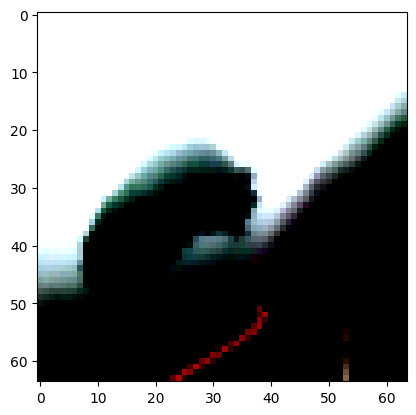

Predicted label: foggy, True label: foggy


In [363]:
# Prediction for dataset4

# iterates through each list created during the test
input_images4 = [img for img in input_images4]
true_labels4 = [lbl for lbl in true_labels4]
predicted_labels4 = [pred for pred in predicted_labels4]

# Indexes a random image from the dataset
index = random.randint(0, len(input_images4) - 1)

# Takes the image, true label and predicted label of indexed image
image4 = input_images4[index]
true_label4 = true_labels4[index]
predicted_label4 = predicted_labels4[index]

# Transforms image for display
image4 = image4.numpy().transpose((1, 2, 0))
plt.imshow(image4)
plt.show()

# Prints true and predicted label with image plot
print(f"Predicted label: {dataset4.classes[predicted_label4]}, True label: {dataset4.classes[true_label4]}")

In [366]:
# transform5 BICUBIC with brightness, contrast, hue, saturation adjustments
transform5 = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BICUBIC),  # Resizes the images to 64x64
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Adjusts brightness, contrast, saturation, and hue randomly
    transforms.ToTensor(), # Converts the images to PyTorch tensors
    transforms.Normalize(mean=[0.4592, 0.4598, 0.4475], std=[0.2189, 0.1987, 0.1856]) # Normalizes tensory array
]) 

In [367]:
# Establishes dataset5 using transform5 method
dataset5 = datasets.ImageFolder(root=data_dir, transform=transform5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  foggy


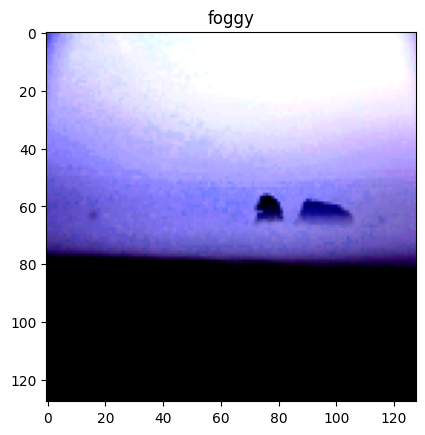

In [373]:
# IMAGE for dataset5

print_transformed_image(dataset5)

In [374]:
# dataset5

# Defines the ratio of the dataset to use for training
train_ratio = 0.8

# Calculates the sizes of the training and testing sets
train_size5 = int(train_ratio * len(dataset5))
test_size5 = len(dataset5) - train_size4

# Uses random_split to split the dataset into training and testing sets
train_dataset5, test_dataset5 = data.random_split(dataset5, [train_size5, test_size5])

In [375]:
batch_size = 15

train_loader5 = data.DataLoader(train_dataset5, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader5 = data.DataLoader(test_dataset5, batch_size=batch_size, shuffle=False, num_workers=4)

# Defines the pretrained ResNet50 model
model5 = models.resnet50(pretrained=True)

# Modifies last layer of model to match dataset2
num_classes = len(dataset5.classes)
model5.fc = nn.Linear(model5.fc.in_features, num_classes)

# Defines the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model5.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [376]:
# Trains dataset5 on the pretrained Resnet50 architecture for 6 epochs
num_epochs = 6

# Stores values from each epoch
train_losses5 = []
train_accs5 = []

# Tracks training time
start_time = time.time()

# Starts training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    # Sets the model to train mode
    model5.train()

    # Initializes the running loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    
    # Iterates over the training data loader
    for inputs, labels in train_loader5:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model5(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Updates running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    # Calculates average training loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataset5)
    train_acc = running_corrects.double() / len(train_dataset5)
    
    # Appends training loss and accuracy to the corresponding lists
    train_losses5.append(train_loss)
    train_accs5.append(train_acc)
    
    # Prints loss and accuracy for each epoch
    print(f"Training loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    
# Tracks training time
end_time = time.time()

training_time = end_time - start_time

print(f"Total training time: {training_time:.2f} seconds")

Epoch 1/6
--------------------
Training loss: 0.6941, accuracy: 0.7675
Epoch 2/6
--------------------
Training loss: 0.1747, accuracy: 0.9500
Epoch 3/6
--------------------
Training loss: 0.1348, accuracy: 0.9575
Epoch 4/6
--------------------
Training loss: 0.1052, accuracy: 0.9667
Epoch 5/6
--------------------
Training loss: 0.0514, accuracy: 0.9892
Epoch 6/6
--------------------
Training loss: 0.0361, accuracy: 0.9900
Total training time: 1113.48 seconds


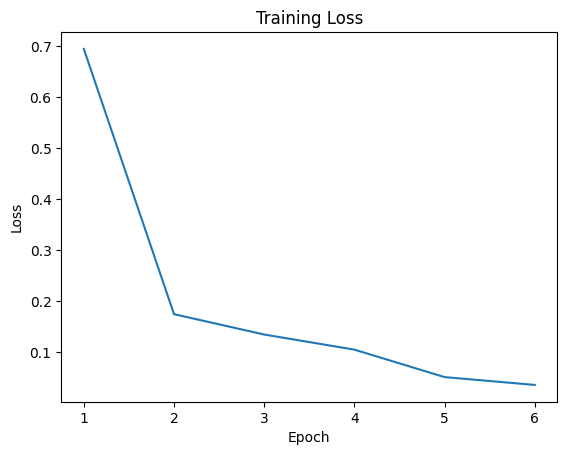

In [390]:
# Training loss over epochs for dataset5

training_loss_plot(train_losses5)

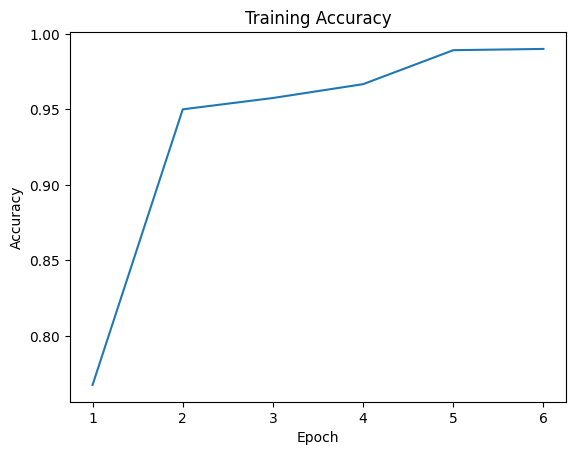

In [391]:
# Training accuracy over epochs for dataset5

training_accuracy_plot(train_accs5)

In [377]:
# dataset5 test

# Stores model5 predictions
input_images5 = []
true_labels5 = []
predicted_labels5 = []

# Evaluate the model on the testing data
model5.eval()

# Tracks testing time
start_time = time.time()

# Starts testing loop
with torch.no_grad():
    # Initializes the running loss and correct predictions
    running_loss = 0.0
    running_corrects = 0

    # Iterates over the testing data loader
    for inputs, labels in test_loader5:
        
        # Stores input images and true labels for later use
        input_images5.extend(inputs)
        true_labels5.extend(labels)

        # Forward pass
        outputs = model5(inputs)
        loss = criterion(outputs, labels)

        # Updates running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
        # Stores predicted labels for later use
        predicted_labels5.extend(preds)

    # Calculates the average testing loss and accuracy for the epoch
    test_loss = running_loss / len(test_dataset5)
    test_acc = running_corrects.double() / len(test_dataset5)
    
    # Prints loss and accuracy for test
    print(f"Testing loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
    
# Tracks testing time
end_time = time.time()

testing_time = end_time - start_time

print(f"Total testing time: {testing_time:.2f} seconds")

Testing loss: 0.1396, accuracy: 0.9500
Total testing time: 32.54 seconds


In [365]:
# Prints out mean and std for pre-normalized datasetX for normalization before running thru model
# After defining a transformX method without normalization, dataset_test was generated using that method
# The formula calculates and prints the mean and std of the tensor array established by the transform method
# Then the transformX function is updated to include the normalization with mean and std
# Once the transformX function is updated with normalization it is trained and tested with the model

dataset_test = datasets.ImageFolder(root=data_dir, transform=transform5)

# Compute the mean and standard deviation of the dataset
data_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1000, shuffle=False, num_workers=0)
mean = 0.0
std = 0.0
for images, _ in data_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(dataset_test)
std /= len(dataset_test)

print('Mean: ', mean)
print('Std: ', std)

Mean:  tensor([0.4592, 0.4598, 0.4475])
Std:  tensor([0.2189, 0.1987, 0.1856])
